### Imports

In [1]:
import re
import os

import seaborn as sns
import plotly.subplots
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import scipy
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf


### Derfaults

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
REMOVE_INTERNATIONAL = True
INTERNATIONAL_LABEL = "International"

PLOTS_PATH = "plots"
PLOTS_PATH_PLT = os.path.join(PLOTS_PATH, "plt")
PLOTS_PATH_PX = os.path.join(PLOTS_PATH, "px")
PLOTS_PATH_HTML = os.path.join(PLOTS_PATH, "html")

FIGURE_WIDTH = 800
FIGURE_HEIGHT = 600

for path in [PLOTS_PATH_PLT, PLOTS_PATH_PX, PLOTS_PATH_HTML]: 
    os.makedirs(path, exist_ok=True)

# Continent Labels

Each article has assigned one continent label.

In [4]:
df_continents = pd.read_csv(os.path.join("Data", "continents.csv"))

if REMOVE_INTERNATIONAL:
    labeled_articles_all_count = len(df_continents)
    df_continents = df_continents[df_continents.continent != INTERNATIONAL_LABEL]
    labeled_articles_count = len(df_continents)
    print(f"Removing articles labeled as {INTERNATIONAL_LABEL}, Removed articles: {labeled_articles_all_count - labeled_articles_count}")

display(df_continents.head())
print("Size:", df_continents.shape)

Removing articles labeled as International, Removed articles: 1870


,article,continent
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Europe
1,%C3%85land,Europe
2,%C3%89douard_Manet,Europe
3,%C3%89ire,Europe
4,%C3%93engus_I_of_the_Picts,Europe


Size: (2734, 2)


### Colors for all plots

In [5]:
continents = df_continents["continent"].unique()
random_colors = sns.color_palette("husl", n_colors=len(continents))
continents_colors = {}
continents_colors_int = {}
for i in range(len(continents)):
    continents_colors[continents[i]] = random_colors[i]
    continents_colors_int[continents[i]] = tuple(map(lambda x: int(255 * x), random_colors[i]))
    continents_colors_int[continents[i]] = "#{0:02x}{1:02x}{2:02x}".format(*continents_colors_int[continents[i]])
print(continents_colors)
print(continents_colors_int)

CONTINENTS_NUM = len(continents_colors)

{'Europe': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'North America': (0.7757319041862729, 0.5784925270759935, 0.19475566538551875), 'Australia': (0.5105309046900421, 0.6614299289084904, 0.1930849118538962), 'Asia': (0.20433460114757862, 0.6863857739476534, 0.5407103379425205), 'Africa': (0.21662978923073606, 0.6676586160122123, 0.7318695594345369), 'South America': (0.5049017849530067, 0.5909119231215284, 0.9584657252128558), 'Antarctica': (0.9587050080494409, 0.3662259565791742, 0.9231469575614251)}
{'Europe': '#f67088', 'North America': '#c59331', 'Australia': '#82a831', 'Asia': '#34af89', 'Africa': '#37aaba', 'South America': '#8096f4', 'Antarctica': '#f45deb'}


In [6]:
continents_grouped = df_continents.groupby(["continent"]).size()
continents_grouped = continents_grouped.sort_values(ascending=False)

display(continents_grouped)

continent
Europe           1245
North America     593
Asia              377
Africa            265
South America     123
Australia         122
Antarctica          9
dtype: int64

In [7]:
if False:
    fig_name = "articles_count_per_continent"

    num_categories = len(continents_grouped.keys())
    ax = plt.bar(continents_grouped.keys(), continents_grouped.values, color=[continents_colors[continent] for continent in continents_grouped.keys()])
    plt.xticks(rotation=45)
    plt.title("Number of articles per continent")
    plt.ylabel("Count")
    plt.xlabel("Continent")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH_PLT, f"{fig_name}_bar.pdf"))
    plt.show()


    fig = go.Figure(data=[go.Bar(
        x=continents_grouped.index,
        y=continents_grouped.values,
        marker_color=[continents_colors_int[continent] for continent in continents_grouped.index],
    )])
    fig.update_layout(
        title_text="Number of articles per continent",
        title_x=0.5,
        #xaxis=dict(tickangle=-45),
        width=FIGURE_WIDTH,
        height=FIGURE_HEIGHT,
    )
    fig.write_image(os.path.join(PLOTS_PATH_PX, f"{fig_name}_bar.pdf"))
    fig.write_html(os.path.join(PLOTS_PATH_HTML, f"{fig_name}_bar.html"))
    fig.show()


    fig = go.Figure(data=[go.Pie(
        labels=continents_grouped.index,
        values=continents_grouped.values,
        pull=[0.2] + [0] * (CONTINENTS_NUM - 1),
        marker_colors=[continents_colors_int[continent] for continent in continents_grouped.index]
    )])

    fig.update_layout(
        title_text="Number of articles per continent",
        title_x=0.5,
        width=FIGURE_WIDTH,
        height=FIGURE_HEIGHT,
    )
    fig.write_image(os.path.join(PLOTS_PATH_PX, f"{fig_name}_pie.pdf"))
    fig.write_html(os.path.join(PLOTS_PATH_HTML, f"{fig_name}_pie.html"))
    fig.show()


# Article wikispeedia category

In [8]:
df_categories = pd.read_csv(
    os.path.join("Data", "wikispeedia_paths-and-graph", "categories.tsv"),
    delimiter="\t",
    header=None,
    names=["article", "category"],
    skip_blank_lines=True,
    comment="#",
    encoding="UTF-8"
)

display(df_categories.head())
print("Size:", df_categories.shape)

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


Size: (5204, 2)


In [9]:
df_continents_categories = pd.merge(df_continents, df_categories, on="article")

display(df_continents_categories.head())
print("Size:", df_continents_categories.shape)

,article,continent,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Europe,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Europe,subject.People.Historical_figures
2,%C3%85land,Europe,subject.Countries
3,%C3%85land,Europe,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,Europe,subject.People.Artists


Size: (3177, 3)


In [10]:
main_categories = []
for category in df_continents_categories["category"].values:
    main_categories.append(category.split(".")[1])

df_continents_categories["categoryMain"] = main_categories

display(df_continents_categories)
print("Size:", df_continents_categories.shape)

,article,continent,category,categoryMain
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Europe,subject.History.British_History.British_Histor...,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Europe,subject.People.Historical_figures,People
2,%C3%85land,Europe,subject.Countries,Countries
3,%C3%85land,Europe,subject.Geography.European_Geography.European_...,Geography
4,%C3%89douard_Manet,Europe,subject.People.Artists,People
...,...,...,...,...
3172,Zionism,Asia,subject.Religion.Religious_movements_tradition...,Religion
3173,Zoroaster,Asia,subject.People.Religious_figures_and_leaders,People
3174,Zuid-Gelders,Europe,subject.Geography.European_Geography,Geography
3175,Zuid-Gelders,Europe,subject.Language_and_literature.Languages,Language_and_literature


Size: (3177, 4)


In [11]:
continents_categories = df_continents_categories.groupby(["categoryMain", "continent"]).size()

if not REMOVE_INTERNATIONAL:
    display(continents_categories[("Geography", "International")])

display(continents_categories)

categoryMain      continent    
Art               Asia              1
                  Europe           13
Business_Studies  Africa            1
                  Asia              6
                  Europe           17
                                   ..
Science           Asia             17
                  Australia        25
                  Europe           33
                  North America    28
                  South America    11
Length: 74, dtype: int64

In [12]:
categories = df_continents_categories["categoryMain"].unique()
continents = df_continents_categories["continent"].unique()
continents.sort()

category_positions = np.arange(len(categories))
bar_width = 0.5

continents_values = {}
for i, continent in enumerate(continents):
    frequencies = []
    for category in categories:
        try:
            value = continents_categories[(category, continent)]
        except KeyError:
            value = 0
        frequencies.append(value)
    continents_values[continent] = frequencies

df_continent_frequencies = pd.DataFrame(continents_values).T
df_continent_frequencies.columns = categories
display(df_continent_frequencies)
print("Size:", df_continent_frequencies.shape)

,History,People,Countries,Geography,Business_Studies,Everyday_life,Music,Language_and_literature,Science,Mathematics,Religion,IT,Citizenship,Design_and_Technology,Art
Africa,30,17,52,143,1,2,2,9,61,0,1,0,4,4,0
Antarctica,0,0,0,7,0,0,0,0,3,0,0,0,0,0,0
Asia,53,51,55,169,6,19,3,14,17,1,29,0,15,11,1
Australia,10,12,15,64,0,5,2,1,25,0,1,0,1,3,0
Europe,313,415,55,287,17,51,33,101,33,0,41,2,33,71,13
North America,53,183,4,166,7,51,18,15,28,0,5,4,26,59,0
South America,9,9,48,85,0,0,10,0,11,0,0,0,1,1,0


Size: (7, 15)


In [13]:
if False:

    fig_name = "articles_count_per_category"
    fig_title = "Continent distribution per Category"
    fig_xlabel = "Article Count"
    fig_ylabel = "Category"


    ig, ax = plt.subplots()
    bottom = np.zeros(len(categories))

    for continent in continents:
        ax.barh(categories, continents_values[continent], label=continent, color=continents_colors[continent], edgecolor="w", height=0.5, left=bottom)
        bottom += continents_values[continent]

    ax.set_yticks(category_positions)
    ax.set_yticklabels(categories)
    ax.set_xlabel(fig_xlabel)
    ax.set_ylabel(fig_ylabel)
    plt.title(fig_title)
    plt.legend()
    plt.savefig(os.path.join(PLOTS_PATH_PLT, f"{fig_name}_bar.pdf"))
    plt.show()


    continent_sorted = df_continent_frequencies.sum(axis="columns").sort_values(ascending=False).index

    fig = px.bar(
        df_continent_frequencies.loc[continent_sorted].T.loc[df_continent_frequencies.sum(axis="index").sort_values().index],
        orientation ="h",
        title=fig_title,
        labels={"index": fig_ylabel, "value": fig_xlabel},
        color_discrete_sequence=[continents_colors_int[continent] for continent in continent_sorted],
    )
    fig.update_layout(
        legend_title_text="",
        title_x=0.5,
        width=FIGURE_WIDTH,
        height=FIGURE_HEIGHT    
    )
    fig.write_html(os.path.join(PLOTS_PATH_HTML, f"{fig_name}_bar.html"))
    fig.write_image(os.path.join(PLOTS_PATH_PX, f"{fig_name}_bar.pdf"))
    fig.show()


    fig = go.Figure()

    annotations = {}
    buttons = []
    visible = True
    mask = [False] * len(categories)
    max_name_len = max(len(name) for name in continents)
    for category_idx, category in enumerate(categories):
        category_data = df_continent_frequencies[category]
        category_data = category_data[category_data > 0]

        category_name = category.replace("_", " ")
        labels = [f"{name : <{max_name_len}}" for name in category_data.index]
        fig.add_trace(go.Pie(
            labels=labels,
            values=category_data.values,
            marker_colors=[continents_colors_int[continent] for continent in category_data.index],
            visible=visible,
            name=category_name
        ))

        annotation = dict(
            text=f"Category: {category_name}",
            x=0.5,
            y=1.1,
            showarrow=False
        )
        if visible:
            fig.add_annotation(annotation)

        mask[category_idx] = True
        buttons.append(dict(
            label=category_name,
            method="update",
            args=[
                {"visible": list(mask)},
                {"title": fig_title, "annotations": [annotation]}
            ]
        ))
        mask[category_idx] = False
        visible=False


    fig.update_layout(
        title_text=fig_title,
        title_x=0.7,
        width=FIGURE_WIDTH,
        height=FIGURE_HEIGHT,
        legend=dict(
            x=-0.3,
            y=0.1
        )
    )


    fig.update_layout(
        updatemenus=[
            dict(
                active=0,
                buttons=buttons
            )
        ]
    )

    fig.write_html(os.path.join(PLOTS_PATH_HTML, f"{fig_name}_pie.html"))
    fig.write_image(os.path.join(PLOTS_PATH_PX, f"{fig_name}_pie.pdf"))
    fig.show()

In [14]:
df_articles = df_continents_categories[["article", "continent"]].drop_duplicates()
df_articles = pd.merge(df_articles, df_continents_categories.groupby("article")["categoryMain"].apply(list).reset_index(), on="article")

display(df_articles.head())
print("Size:", df_articles.shape)

,article,continent,categoryMain
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Europe,"[History, People]"
1,%C3%85land,Europe,"[Countries, Geography]"
2,%C3%89douard_Manet,Europe,[People]
3,%C3%89ire,Europe,"[Countries, Geography]"
4,%C3%93engus_I_of_the_Picts,Europe,"[History, People]"


Size: (2734, 3)


## Length of articles

In [15]:
plaintext_path = os.path.join("Data", "plaintext_articles")

word_counts = []
for article_name in df_articles.article:
    file_path = os.path.join(plaintext_path, article_name + ".txt")

    with open(file_path, "r", encoding="utf-8") as file:

        _ = file.readline() # Skip the first line because it contains the word #copyright
        content = file.read()

    content = content[:re.search("Retrieved from", content).start(0)]
    word_counts.append(len(content.split()))

df_articles["length"] = word_counts

display(df_articles.head())
print("Size:", df_articles.shape)

,article,continent,categoryMain,length
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Europe,"[History, People]",1836
1,%C3%85land,Europe,"[Countries, Geography]",2412
2,%C3%89douard_Manet,Europe,[People],2887
3,%C3%89ire,Europe,"[Countries, Geography]",2026
4,%C3%93engus_I_of_the_Picts,Europe,"[History, People]",2029


Size: (2734, 4)


In [16]:
continent_length = df_articles.groupby(["continent"]).length.agg(scipy.stats.gmean)
continent_length = continent_length.sort_values(ascending=False)

display(continent_length)
print("Size:", continent_length.shape)

continent
North America    3016.458447
Asia             2957.833657
Europe           2773.623888
Australia        2063.341870
South America    2031.787167
Antarctica       1611.262593
Africa           1368.348439
Name: length, dtype: float64

Size: (7,)


In [17]:
if False:

    fig_name = "gmean_length_of_articles_by_continent"
    fig_title = "Length of articles by continent (Geometric mean)"
    fig_xlabel = "Continent"
    fig_ylabel = "World count"

    ax = plt.bar(
        continent_length.index,
        continent_length.values.reshape(continent_length.shape[0]),
        color=[continents_colors[continent] for continent in continent_length.index]
    )
    plt.xticks(rotation=45)

    plt.xlabel(fig_xlabel)
    plt.ylabel(fig_ylabel)
    plt.title(fig_title)
    plt.savefig(os.path.join(PLOTS_PATH_PLT, f"{fig_name}_bar.pdf"))
    plt.show()

    fig = px.bar(
        x=continent_length.index,
        y=continent_length.values.reshape(continent_length.shape[0]),
        labels={"x": fig_xlabel, "y": fig_ylabel},
        title="Length of articles by continent (Geometric mean)",
        color=[continents_colors_int[continent] for continent in continent_length.index],
        color_discrete_map="identity",
        width=FIGURE_WIDTH,
        height=FIGURE_HEIGHT
    )

    fig.update_layout(
        showlegend=False,
        title_x=0.5
    )
    fig.write_html(os.path.join(PLOTS_PATH_HTML, f"{fig_name}_bar.html"))
    fig.write_image(os.path.join(PLOTS_PATH_PX, f"{fig_name}_bar.pdf"))
    fig.show()

## Pagerank

In [18]:
# Load pagerank
df_pagerank = pd.read_csv(os.path.join("Data", "page_rank.csv"))

display(df_pagerank.head())
print("Size:", df_pagerank.shape)

,article,pageRank
0,United_States,0.014263
1,United_Kingdom,0.007679
2,Scientific_classification,0.007209
3,Europe,0.007043
4,England,0.006815


Size: (4592, 2)


In [19]:
df_articles = pd.merge(df_articles, df_pagerank, on="article", how="left").fillna(1e-6)

display(df_articles.head())
print("Size:", df_articles.shape)

,article,continent,categoryMain,length,pageRank
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Europe,"[History, People]",1836,0.000033
1,%C3%85land,Europe,"[Countries, Geography]",2412,0.000033
2,%C3%89douard_Manet,Europe,[People],2887,0.000033
3,%C3%89ire,Europe,"[Countries, Geography]",2026,0.000033
4,%C3%93engus_I_of_the_Picts,Europe,"[History, People]",2029,0.000033


Size: (2734, 5)


In [20]:
# Compute mean
pagerank_continent_mean = df_articles.groupby("continent")["pageRank"].agg(scipy.stats.gmean)
pagerank_continent_mean = pagerank_continent_mean.sort_values(ascending=False)

# Compute mean
pagerank_continent_median = df_articles.groupby("continent")["pageRank"].median()
pagerank_continent_median = pagerank_continent_median.sort_values(ascending=False)

In [21]:
if False:
    fig_name = "gmean_pagerank_by_continet"
    fig_title = "PageRank by continent (Geometric Mean)"
    fig_xlabel = "Continent"
    fig_ylabel = "PageRank"

    ax = plt.bar(
        pagerank_continent_mean.index,
        pagerank_continent_mean,
        color=[continents_colors[continent] for continent in pagerank_continent_mean.index]
    )
    plt.xticks(rotation=45)

    plt.xlabel(fig_xlabel)
    plt.ylabel(fig_ylabel)
    plt.title(fig_title)
    plt.savefig(os.path.join(PLOTS_PATH_PLT, f"{fig_name}_bar.pdf"))
    plt.show()

    fig = px.bar(
        x=pagerank_continent_mean.index,
        y=pagerank_continent_mean,
        labels={"x": fig_xlabel, "y": fig_ylabel},
        title=fig_title,
        color=[continents_colors_int[continent] for continent in pagerank_continent_mean.index],
        color_discrete_map="identity",
        width=FIGURE_WIDTH,
        height=FIGURE_HEIGHT
    )
    fig.update_layout(
        showlegend=False,
        title_x=0.5
    )
    fig.update_yaxes(tickformat=".1e")
    fig.write_html(os.path.join(PLOTS_PATH_HTML, f"{fig_name}_bar.html"))
    fig.write_image(os.path.join(PLOTS_PATH_PX, f"{fig_name}_bar.pdf"))
    fig.show()

In [22]:
if False:
    fig_name = "median_pagerank_by_continet"
    fig_title = "PageRank by continent (Geometric Median)"
    fig_xlabel = "Continent"
    fig_ylabel = "PageRank"

    ax = plt.bar(pagerank_continent_median.index, pagerank_continent_median, color=[continents_colors[continent] for continent in pagerank_continent_median.index])
    plt.xticks(rotation=45)

    plt.xlabel(fig_xlabel)
    plt.ylabel(fig_ylabel)
    plt.title(fig_title)
    plt.savefig(os.path.join(PLOTS_PATH_PLT, f"{fig_name}_bar.pdf"))
    plt.show()

    fig = px.bar(
        x=pagerank_continent_median.index,
        y=pagerank_continent_median,
        labels={"x": fig_xlabel, "y": fig_ylabel},
        title=fig_title,
        color=[continents_colors_int[continent] for continent in pagerank_continent_median.index],
        color_discrete_map="identity",
        width=FIGURE_WIDTH,
        height=FIGURE_HEIGHT
    )
    fig.update_layout(
        showlegend=False,
        title_x=0.5
    )
    fig.update_yaxes(tickformat=".1e")
    fig.write_html(os.path.join(PLOTS_PATH_HTML, f"{fig_name}_bar.html"))
    fig.write_image(os.path.join(PLOTS_PATH_PX, f"{fig_name}_bar.pdf"))
    fig.show()

## Analysis of paths

Group paths by continents, one path will be assigned to the continent corresponding to the GOAL article

Compute the number of "backclicks" in each path

Compute the length of each path

In [23]:
df_paths_finished = pd.read_csv(
    os.path.join("Data", "wikispeedia_paths-and-graph", "paths_finished.tsv"),
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    skip_blank_lines=True,
    comment="#"
)
df_paths_unfinished = pd.read_csv(
    os.path.join("Data", "wikispeedia_paths-and-graph", "paths_unfinished.tsv"),
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "motif"],
    skip_blank_lines=True,
    comment="#"
)

df_paths_finished["backclicks"] = df_paths_finished["path"].apply(lambda x: x.count("<"))
df_paths_finished["pathSteps"] = df_paths_finished["path"].apply(lambda x: x.count(";") + 1)
df_paths_finished["uniqueArticles"] = df_paths_finished["pathSteps"] - df_paths_finished["backclicks"]
df_paths_finished["path"] = df_paths_finished["path"].apply(lambda x: x.split(";"))
df_paths_finished["start"] = df_paths_finished["path"].str[0]
df_paths_finished["target"] = df_paths_finished["path"].str[-1]
df_paths_finished["isFinished"] = True

df_paths_unfinished["backclicks"] = df_paths_unfinished["path"].apply(lambda x: x.count("<"))
df_paths_unfinished["pathSteps"] = df_paths_unfinished["path"].apply(lambda x: x.count(";") + 1)
df_paths_unfinished["uniqueArticles"] = df_paths_unfinished["pathSteps"] - df_paths_unfinished["backclicks"]
df_paths_unfinished["path"] = df_paths_unfinished["path"].apply(lambda x: x.split(";"))
df_paths_unfinished["start"] = df_paths_unfinished["path"].str[0]
df_paths_unfinished["isFinished"] = False

display(df_paths_finished.head())
display(df_paths_unfinished.head())

df_paths = pd.concat([df_paths_finished, df_paths_unfinished])
display(df_paths.head())

,hashedIpAddress,timestamp,durationInSec,path,rating,backclicks,pathSteps,uniqueArticles,start,target,isFinished
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,0,9,9,14th_century,African_slave_trade,True
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,0,5,5,14th_century,African_slave_trade,True
2,415612e93584d30e,1349298640,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,0,8,8,14th_century,African_slave_trade,True
3,64dd5cd342e3780c,1265613925,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,0,4,4,14th_century,Greece,True
4,015245d773376aab,1366730828,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,0,7,7,14th_century,John_F._Kennedy,True


,hashedIpAddress,timestamp,durationInSec,path,target,motif,backclicks,pathSteps,uniqueArticles,start,isFinished
0,2426091a53125110,1297054935,1804,[Obi-Wan_Kenobi],Microsoft,timeout,0,1,1,Obi-Wan_Kenobi,False
1,26141fd878806294,1297055651,1805,[Julius_Caesar],Caracas,timeout,0,1,1,Julius_Caesar,False
2,2b015fb8181c48f2,1297090819,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,0,3,3,Malawi,False
3,53a53bc244e08a6a,1297094761,49,[Paraguay],Mount_St._Helens,restart,0,1,1,Paraguay,False
4,53a53bc244e08a6a,1297099105,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,0,2,2,Paraguay,False


,hashedIpAddress,timestamp,durationInSec,path,rating,backclicks,pathSteps,uniqueArticles,start,target,isFinished,motif
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,0,9,9,14th_century,African_slave_trade,True,NaN
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,0,5,5,14th_century,African_slave_trade,True,NaN
2,415612e93584d30e,1349298640,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,0,8,8,14th_century,African_slave_trade,True,NaN
3,64dd5cd342e3780c,1265613925,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,0,4,4,14th_century,Greece,True,NaN
4,015245d773376aab,1366730828,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,0,7,7,14th_century,John_F._Kennedy,True,NaN


In [24]:
tmp = df_articles.copy()
tmp.columns = [column[0].upper() + column[1:] for column in tmp.columns]
tmp = tmp.add_prefix("target")

df_analysis = pd.merge(df_paths, tmp, left_on="target", right_on="targetArticle", suffixes=["", ]).drop(columns="targetArticle")

tmp = df_articles.copy()
tmp.columns = [column[0].upper() + column[1:] for column in tmp.columns]
tmp = tmp.add_prefix("start")
df_analysis = pd.merge(df_analysis, tmp, left_on="start", right_on="startArticle", suffixes=["", ]).drop(columns="startArticle")

df_analysis["isFinishedInt"] = df_analysis["isFinished"].astype(int)

display(df_analysis.head())
print("Size:", df_analysis.shape)

,hashedIpAddress,timestamp,durationInSec,path,rating,backclicks,pathSteps,uniqueArticles,start,target,...,motif,targetContinent,targetCategoryMain,targetLength,targetPageRank,startContinent,startCategoryMain,startLength,startPageRank,isFinishedInt
0,1a218aa161301e6e,1355086784,40,"[James_Bond, United_Kingdom, Europe, Africa, A...",NaN,0,6,6,James_Bond,African_slave_trade,...,NaN,Africa,[History],2654,0.000055,Europe,[Everyday_life],7496,0.000186,1
1,1ad6fbd964102221,1332642329,144,"[James_Bond, Star_Wars, Mythology, The_Lord_of...",NaN,5,11,6,James_Bond,Iron_Maiden,...,restart,Europe,[Music],4047,0.000159,Europe,[Everyday_life],7496,0.000186,0
2,3e6b12634169fb72,1357250279,28,"[James_Bond, Sean_Connery, Scotland, Scottish_...",NaN,0,4,4,James_Bond,Scottish_Gaelic_language,...,NaN,Europe,[Language_and_literature],4780,0.000243,Europe,[Everyday_life],7496,0.000186,1
3,2141997163054c23,1272956123,18,"[James_Bond, United_States, Canada, Stephen_Ha...",NaN,0,4,4,James_Bond,Stephen_Harper,...,NaN,North America,[People],4801,0.000107,Europe,[Everyday_life],7496,0.000186,1
4,15945db656214ee5,1253827056,64,"[James_Bond, Germany, Adolf_Hitler, Nazi_Germa...",NaN,0,5,5,James_Bond,Nazism,...,NaN,Europe,[History],7377,0.000706,Europe,[Everyday_life],7496,0.000186,1


Size: (19164, 21)


In [25]:
df_analysis_finished = df_analysis[df_analysis["isFinished"]]
df_analysis_unfinished = df_analysis[~df_analysis["isFinished"]]

df_analysis_per_continent = pd.DataFrame()
for name in ["start", "target"]:
    # Create a column to show the number of articles in each continent
    df_analysis_per_continent[f"{name}Articles"] = df_analysis.groupby(f"{name}Continent").size()

    # Create columns for av. backclicks
    df_analysis_per_continent[f"{name}BackcliksFinished"] =  df_analysis_finished.groupby(f"{name}Continent")["backclicks"].agg(scipy.stats.gmean)
    df_analysis_per_continent[f"{name}BackcliksUnfinished"] =  df_analysis_unfinished.groupby(f"{name}Continent")["backclicks"].agg(scipy.stats.gmean)

    # Create columns for av. path steps
    df_analysis_per_continent[f"{name}PathStepsFinished"] =  df_analysis_finished.groupby(f"{name}Continent")["pathSteps"].agg(scipy.stats.gmean)
    df_analysis_per_continent[f"{name}PathStepsUnfinished"] =  df_analysis_unfinished.groupby(f"{name}Continent")["pathSteps"].agg(scipy.stats.gmean)

    # Create columns for the number of finished and unfinished paths for each continent
    df_analysis_per_continent[f"{name}PathsFinished"] = df_analysis_finished[f"{name}Continent"].value_counts()
    df_analysis_per_continent[f"{name}PathsUnfinished"] = df_analysis_unfinished[f"{name}Continent"].value_counts()
    df_analysis_per_continent[f"{name}PathsFinishedPercentage"] = df_analysis.groupby(f"{name}Continent")["isFinishedInt"].mean() * 100

df_analysis_per_continent.index.name = "continent"

In [26]:
continent_data = df_analysis_per_continent.sort_values(by="targetPathsFinishedPercentage",ascending=False)
display(continent_data)
print("Size:", continent_data.shape)

,startArticles,startBackcliksFinished,startBackcliksUnfinished,startPathStepsFinished,startPathStepsUnfinished,startPathsFinished,startPathsUnfinished,startPathsFinishedPercentage,targetArticles,targetBackcliksFinished,targetBackcliksUnfinished,targetPathStepsFinished,targetPathStepsUnfinished,targetPathsFinished,targetPathsUnfinished,targetPathsFinishedPercentage
continent,,,,,,,,,,,,,,,,
Asia,2818,0.0,0.0,5.359805,3.494532,2006,812,71.185238,3037,0.0,0.0,5.196041,3.358903,2302,735,75.798485
South America,873,0.0,0.0,5.383479,3.485587,611,262,69.988545,966,0.0,0.0,5.611084,3.310156,732,234,75.776398
Africa,1870,0.0,0.0,5.386258,3.516431,1372,498,73.368984,1933,0.0,0.0,5.664175,3.360493,1403,530,72.581480
Europe,8234,0.0,0.0,5.405634,3.414763,5827,2407,70.767549,8145,0.0,0.0,5.297494,3.320780,5836,2309,71.651320
Australia,772,0.0,0.0,5.199904,3.418933,538,234,69.689119,689,0.0,0.0,5.497121,3.543008,452,237,65.602322
North America,4510,0.0,0.0,5.426477,3.478513,3156,1354,69.977827,4256,0.0,0.0,5.531919,3.842311,2763,1493,64.920113
Antarctica,87,0.0,0.0,5.377309,3.779016,65,22,74.712644,138,0.0,0.0,6.143688,2.041836,87,51,63.043478


Size: (7, 16)


In [27]:
continent_data = df_analysis_per_continent.sort_values(by="startPathsFinishedPercentage",ascending=False)
display(continent_data)
print("Size:", continent_data.shape)

,startArticles,startBackcliksFinished,startBackcliksUnfinished,startPathStepsFinished,startPathStepsUnfinished,startPathsFinished,startPathsUnfinished,startPathsFinishedPercentage,targetArticles,targetBackcliksFinished,targetBackcliksUnfinished,targetPathStepsFinished,targetPathStepsUnfinished,targetPathsFinished,targetPathsUnfinished,targetPathsFinishedPercentage
continent,,,,,,,,,,,,,,,,
Antarctica,87,0.0,0.0,5.377309,3.779016,65,22,74.712644,138,0.0,0.0,6.143688,2.041836,87,51,63.043478
Africa,1870,0.0,0.0,5.386258,3.516431,1372,498,73.368984,1933,0.0,0.0,5.664175,3.360493,1403,530,72.581480
Asia,2818,0.0,0.0,5.359805,3.494532,2006,812,71.185238,3037,0.0,0.0,5.196041,3.358903,2302,735,75.798485
Europe,8234,0.0,0.0,5.405634,3.414763,5827,2407,70.767549,8145,0.0,0.0,5.297494,3.320780,5836,2309,71.651320
South America,873,0.0,0.0,5.383479,3.485587,611,262,69.988545,966,0.0,0.0,5.611084,3.310156,732,234,75.776398
North America,4510,0.0,0.0,5.426477,3.478513,3156,1354,69.977827,4256,0.0,0.0,5.531919,3.842311,2763,1493,64.920113
Australia,772,0.0,0.0,5.199904,3.418933,538,234,69.689119,689,0.0,0.0,5.497121,3.543008,452,237,65.602322


Size: (7, 16)


In [28]:
if False:
    fig_name = "count_target_by_continet"
    fig_title = "Target articles by continent"
    fig_xlabel = "Continent"
    fig_ylabel = "Count"

    ax = plt.bar(continent_data.index,continent_data["targetArticles"], color=[continents_colors[continent] for continent in continent_data.index])
    plt.xticks(rotation=45)

    plt.xlabel(fig_xlabel)
    plt.ylabel(fig_ylabel)
    plt.title(fig_title)
    plt.savefig(os.path.join(PLOTS_PATH_PLT, f"{fig_name}_bar.pdf"))
    plt.show()

    fig = px.bar(
        x=continent_data.index,
        y=continent_data["targetArticles"],
        labels={"x": fig_xlabel, "y": fig_ylabel},
        title=fig_title,
        color=[continents_colors_int[continent] for continent in continent_data.index],
        color_discrete_map="identity"
    )

    fig.update_layout(
        showlegend=False,
        title_x=0.5,
        width=FIGURE_WIDTH,
        height=FIGURE_HEIGHT
    )
    fig.write_html(os.path.join(PLOTS_PATH_HTML, f"{fig_name}_bar.html"))
    fig.write_image(os.path.join(PLOTS_PATH_PX, f"{fig_name}_bar.pdf"))
    fig.show()

In [29]:
if False:
    fig_name = "count_start_by_continet"
    fig_title = "Start articles by continent"
    fig_xlabel = "Continent"
    fig_ylabel = "Count"

    ax = plt.bar(continent_data.index,continent_data["startArticles"], color=[continents_colors[continent] for continent in continent_data.index])
    plt.xticks(rotation=45)

    plt.xlabel(fig_xlabel)
    plt.ylabel(fig_ylabel)
    plt.title(fig_title)
    plt.savefig(os.path.join(PLOTS_PATH_PLT, f"{fig_name}_bar.pdf"))
    plt.show()

    fig = px.bar(
        x=continent_data.index,
        y=continent_data["startArticles"],
        labels={"x": fig_xlabel, "y": fig_ylabel},
        title=fig_title,
        color=[continents_colors_int[continent] for continent in continent_data.index],
        color_discrete_map="identity"
    )

    fig.update_layout(
        showlegend=False,
        title_x=0.5,
        width=FIGURE_WIDTH,
        height=FIGURE_HEIGHT
    )
    fig.write_html(os.path.join(PLOTS_PATH_HTML, f"{fig_name}_bar.html"))
    fig.write_image(os.path.join(PLOTS_PATH_PX, f"{fig_name}_bar.pdf"))
    fig.show()

In [30]:
df_article_path_stats = pd.DataFrame()

df_article_path_stats["article"] = df_articles["article"]
df_article_path_stats["continent"] = df_articles["continent"]
df_article_path_stats["targetFinished"] = df_articles["article"].map(df_paths_finished["target"].value_counts()).fillna(0)
df_article_path_stats["targetUnfinished"] = df_articles["article"].map(df_paths_unfinished["target"].value_counts()).fillna(0)

df_article_path_stats["startFinished"] = df_articles["article"].map(df_paths_finished["start"].value_counts()).fillna(0)
df_article_path_stats["startUnfinished"] = df_articles["article"].map(df_paths_unfinished["start"].value_counts()).fillna(0)

paths_finished = pd.Series(np.concatenate(df_paths_finished.path.values))
paths_unfinished = pd.Series(np.concatenate(df_paths_unfinished.path.values))

# Create columns to count the number of times each article appears in general in finished and unfinished paths
df_article_path_stats["anyFinished"] = df_articles["article"].map(paths_finished.value_counts()).fillna(0)
df_article_path_stats["anyUnfinished"] = df_articles["article"].map(paths_unfinished.value_counts()).fillna(0)

# Let"s calculate the probability of finding an article (we can compare this with the pagerank)
df_article_path_stats["anyPercentage"] = (df_article_path_stats["anyFinished"] + df_article_path_stats["anyUnfinished"]) / (len(paths_finished) + len(paths_unfinished))

In [31]:
display(df_article_path_stats.sort_values("anyPercentage", ascending=False).head())
print("Size:", df_article_path_stats.shape)

,article,continent,targetFinished,targetUnfinished,startFinished,startUnfinished,anyFinished,anyUnfinished,anyPercentage
2563,United_States,North America,28.0,3.0,44.0,7.0,8896.0,3553.0,0.026149
827,Europe,Europe,17.0,2.0,26.0,15.0,4362.0,1249.0,0.011786
2560,United_Kingdom,Europe,28.0,0.0,16.0,6.0,3904.0,1424.0,0.011192
803,England,Europe,111.0,14.0,98.0,45.0,3332.0,1226.0,0.009574
62,Africa,Africa,28.0,5.0,75.0,23.0,2796.0,794.0,0.007541


Size: (2734, 9)


In [32]:
if False:
    fig_name = "article_occurrence_by_continet"
    fig_title = "Occurrence of article in path per continent (Median)"
    fig_xlabel = "Continent"
    fig_ylabel = "Percentage"


    tmp = df_article_path_stats.groupby("continent")
    tmp = tmp.anyPercentage.median()

    ax = plt.bar(tmp.index, tmp, color=[continents_colors[continent] for continent in tmp.index])
    plt.xticks(rotation=45)

    plt.xlabel(fig_xlabel)
    plt.ylabel(fig_ylabel)
    plt.title(fig_title)
    plt.show()

    fig = px.bar(
        x=tmp.index,
        y=tmp,
        labels={"x": fig_xlabel, "y": fig_ylabel},
        title=fig_title,
        color=[continents_colors_int[continent] for continent in tmp.index],
        color_discrete_map="identity"
    )

    fig.update_layout(
        showlegend=False,
        title_x=0.5,
        width=FIGURE_WIDTH,
        height=FIGURE_HEIGHT
    )
    fig.write_html(os.path.join(PLOTS_PATH_HTML, f"{fig_name}_bar.html"))
    fig.write_image(os.path.join(PLOTS_PATH_PX, f"{fig_name}_bar.pdf"))
    fig.show()

In [33]:
if False:
    fig_name = "median_pagerank_by_continet"
    fig_title = "Percentage of finished paths by continent"
    fig_xlabel = "Continent"
    fig_ylabel = "Percentage"

    ax = plt.bar(continent_data.index, continent_data["targetPathsFinishedPercentage"], color=[continents_colors[continent] for continent in continent_data.index])
    plt.xticks(rotation=45)
    plt.xlabel(fig_xlabel)
    plt.ylabel(fig_ylabel)
    plt.title(fig_title)
    plt.savefig(os.path.join(PLOTS_PATH_PLT, f"{fig_name}_bar.pdf"))
    plt.show()

    fig = px.bar(
        x=continent_data.index,
        y=continent_data["targetPathsFinishedPercentage"],
        labels={"x": fig_xlabel, "y": fig_ylabel},
        title=fig_title,
        color=[continents_colors_int[continent] for continent in continent_data.index],
        color_discrete_map="identity"
    )
    fig.update_layout(
        showlegend=False,
        title_x=0.5,
        width=FIGURE_WIDTH,
        height=FIGURE_HEIGHT
    )
    fig.write_html(os.path.join(PLOTS_PATH_HTML, f"{fig_name}_bar.html"))
    fig.write_image(os.path.join(PLOTS_PATH_PX, f"{fig_name}_bar.pdf"))
    fig.show()

In [34]:
df_analysis["treatment"] = df_analysis.targetContinent == "Europe"

In [35]:
scipy.stats.ttest_ind(df_analysis[df_analysis.treatment]["isFinishedInt"], df_analysis[~df_analysis.treatment]["isFinishedInt"], equal_var=False)

TtestResult(statistic=2.1398924823233725, pvalue=0.03237710067318371, df=17683.77846200103)

In [36]:
cross_tab = pd.crosstab(df_analysis['treatment'], df_analysis['isFinished'], margins=True, margins_name='Total')
proportions = cross_tab.div(cross_tab['Total'], axis=0).iloc[:-1, :-1]
standard_errors = proportions.apply(lambda x: x**0.5 * ((1 - x) / x / cross_tab['Total'][:-1])**0.5, axis=0)

print(proportions, standard_errors)


if False:
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=[f'Treatment {group}' for group in proportions.index],
        y=proportions[True],
        error_y=dict(type='data', array=standard_errors[True]),
    ))

    fig.update_layout(
        title='Proportion of Finished Samples',
        xaxis=dict(title='Treatment'),
        yaxis=dict(title='Proportion'),
        barmode='group',
    )

    fig.show()


isFinished     False      True
treatment                     
False       0.297668  0.702332
True        0.283487  0.716513 isFinished     False      True
treatment                     
False       0.007984  0.005198
True        0.009379  0.005900


# Testing dependance of variables

In [37]:
df_articles_all = pd.read_csv(
    os.path.join("Data", "wikispeedia_paths-and-graph", "articles.tsv"),
    delimiter="\t",
    header=None,
    names=["name"],
    skip_blank_lines=True,
    comment="#",
    encoding="UTF-8"
)

name_to_index = dict(zip(df_articles_all["name"], df_articles_all.index))

display(df_articles_all.head())
print("Size:", df_articles_all.shape)

,name
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


Size: (4604, 1)


In [38]:
sp_lenght = []

with open(os.path.join("Data", "wikispeedia_paths-and-graph", "shortest-path-distance-matrix.txt")) as file:
    for line in file:
        line = line.strip()
        if line == "" or line.startswith("#"):
            continue
    
        sp_lenght.append(list(map(lambda x: -1 if x == "_" else int(x), list(line))))
        
sp_lenght = np.array(sp_lenght)

print(sp_lenght[:10, :10])

[[ 0 -1 -1 -1 -1 -1  3  3  3  3]
 [-1  0 -1 -1 -1 -1  2  2  2  2]
 [-1 -1  0 -1 -1 -1  3  3  2  2]
 [-1 -1 -1  0 -1 -1  3  3  3  3]
 [-1 -1 -1 -1  0 -1  2  2  3  2]
 [-1 -1 -1 -1 -1  0  3  2  2  2]
 [-1 -1 -1 -1 -1 -1  0  1  2  2]
 [-1 -1 -1 -1 -1 -1  1  0  1  1]
 [-1 -1 -1 -1 -1 -1  1  1  0  1]
 [-1 -1 -1 -1 -1 -1  2  2  1  0]]


In [39]:
df_analysis["startIdx"] = df_analysis["start"].replace(name_to_index)
df_analysis["targetIdx"] = df_analysis["target"].replace(name_to_index)

df_analysis["shortestPath"] = df_analysis.apply(lambda x: sp_lenght[x["startIdx"]][x["targetIdx"]], axis="columns")

In [40]:
df_analysis.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,backclicks,pathSteps,uniqueArticles,start,target,...,targetPageRank,startContinent,startCategoryMain,startLength,startPageRank,isFinishedInt,treatment,startIdx,targetIdx,shortestPath
0,1a218aa161301e6e,1355086784,40,"[James_Bond, United_Kingdom, Europe, Africa, A...",NaN,0,6,6,James_Bond,African_slave_trade,...,0.000055,Europe,[Everyday_life],7496,0.000186,1,False,2206,143,3
1,1ad6fbd964102221,1332642329,144,"[James_Bond, Star_Wars, Mythology, The_Lord_of...",NaN,5,11,6,James_Bond,Iron_Maiden,...,0.000159,Europe,[Everyday_life],7496,0.000186,0,True,2206,2159,2
2,3e6b12634169fb72,1357250279,28,"[James_Bond, Sean_Connery, Scotland, Scottish_...",NaN,0,4,4,James_Bond,Scottish_Gaelic_language,...,0.000243,Europe,[Everyday_life],7496,0.000186,1,True,2206,3659,2
3,2141997163054c23,1272956123,18,"[James_Bond, United_States, Canada, Stephen_Ha...",NaN,0,4,4,James_Bond,Stephen_Harper,...,0.000107,Europe,[Everyday_life],7496,0.000186,1,False,2206,3890,2
4,15945db656214ee5,1253827056,64,"[James_Bond, Germany, Adolf_Hitler, Nazi_Germa...",NaN,0,5,5,James_Bond,Nazism,...,0.000706,Europe,[Everyday_life],7496,0.000186,1,True,2206,2938,2


In [41]:
df_analysis_onehot = df_analysis.copy()

for col in ["startContinent", "startCategoryMain", "targetContinent", "targetCategoryMain"]:
    one_hot = pd.get_dummies(df_analysis[col].explode()).groupby(level=0).sum()
    one_hot = one_hot.add_prefix(f"{col}OneHot")

    df_analysis_onehot = pd.concat((df_analysis_onehot, one_hot), axis="columns")

df_analysis_onehot.columns = [col.replace(" ", "_") for col in df_analysis_onehot.columns]

In [42]:
corr_cols = ["backclicks", "pathSteps", "uniqueArticles", "targetLength", "targetPageRank", "startLength", "startPageRank", "isFinished", "shortestPath"] + [col for col in df_analysis_onehot.columns if "OneHot" in col]
display(df_analysis_onehot[corr_cols].corr()["isFinished"])
display(df_analysis_onehot[corr_cols].corr("spearman")["isFinished"])


backclicks                                        -0.079117
pathSteps                                          0.088762
uniqueArticles                                     0.142245
targetLength                                       0.115741
targetPageRank                                     0.153329
startLength                                        0.000512
startPageRank                                      0.015092
isFinished                                         1.000000
shortestPath                                      -0.330131
startContinentOneHotAfrica                         0.018326
startContinentOneHotAntarctica                     0.005760
startContinentOneHotAsia                           0.003191
startContinentOneHotAustralia                     -0.005169
startContinentOneHotEurope                        -0.001306
startContinentOneHotNorth_America                 -0.010474
startContinentOneHotSouth_America                 -0.004073
startCategoryMainOneHotArt              

backclicks                                        -0.086289
pathSteps                                          0.245176
uniqueArticles                                     0.276461
targetLength                                       0.114842
targetPageRank                                     0.334533
startLength                                       -0.002406
startPageRank                                      0.015190
isFinished                                         1.000000
shortestPath                                      -0.321359
startContinentOneHotAfrica                         0.018326
startContinentOneHotAntarctica                     0.005760
startContinentOneHotAsia                           0.003191
startContinentOneHotAustralia                     -0.005169
startContinentOneHotEurope                        -0.001306
startContinentOneHotNorth_America                 -0.010474
startContinentOneHotSouth_America                 -0.004073
startCategoryMainOneHotArt              

In [43]:
features = [col for col in df_analysis_onehot.columns if "CategoryMainOneHot" in col] + ["startLength", "startPageRank", "targetLength", "targetPageRank", "shortestPath"]
eq = "isFinishedInt ~ " + " + ".join(features)

model = smf.logit(eq, df_analysis_onehot).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.531943
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          isFinishedInt   No. Observations:                19164
Model:                          Logit   Df Residuals:                    19128
Method:                           MLE   Df Model:                           35
Date:                Wed, 20 Dec 2023   Pseudo R-squ.:                  0.1187
Time:                        15:40:55   Log-Likelihood:                -10194.
converged:                       True   LL-Null:                       -11568.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                         

In [44]:
pvalues = model.pvalues
print(pvalues[pvalues < 0.05])

Intercept                                         9.060700e-96
startCategoryMainOneHotIT                         2.959231e-03
targetCategoryMainOneHotBusiness_Studies          2.301080e-04
targetCategoryMainOneHotDesign_and_Technology     7.117545e-04
targetCategoryMainOneHotGeography                 9.556004e-12
targetCategoryMainOneHotHistory                   2.867147e-02
targetCategoryMainOneHotMusic                     4.018602e-02
targetCategoryMainOneHotPeople                    1.152992e-02
targetCategoryMainOneHotScience                   3.528086e-02
startLength                                       4.603880e-12
startPageRank                                     8.477978e-06
targetLength                                      1.642249e-06
targetPageRank                                    1.073520e-11
shortestPath                                     3.262175e-217
dtype: float64


In [45]:
eq = "isFinishedInt ~ " + " + ".join(x for x in pvalues[pvalues < 0.05].index if x != "Intercept")

model = smf.logit(eq, df_analysis_onehot).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.533174
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          isFinishedInt   No. Observations:                19164
Model:                          Logit   Df Residuals:                    19150
Method:                           MLE   Df Model:                           13
Date:                Wed, 20 Dec 2023   Pseudo R-squ.:                  0.1167
Time:                        15:40:55   Log-Likelihood:                -10218.
converged:                       True   LL-Null:                       -11568.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                             

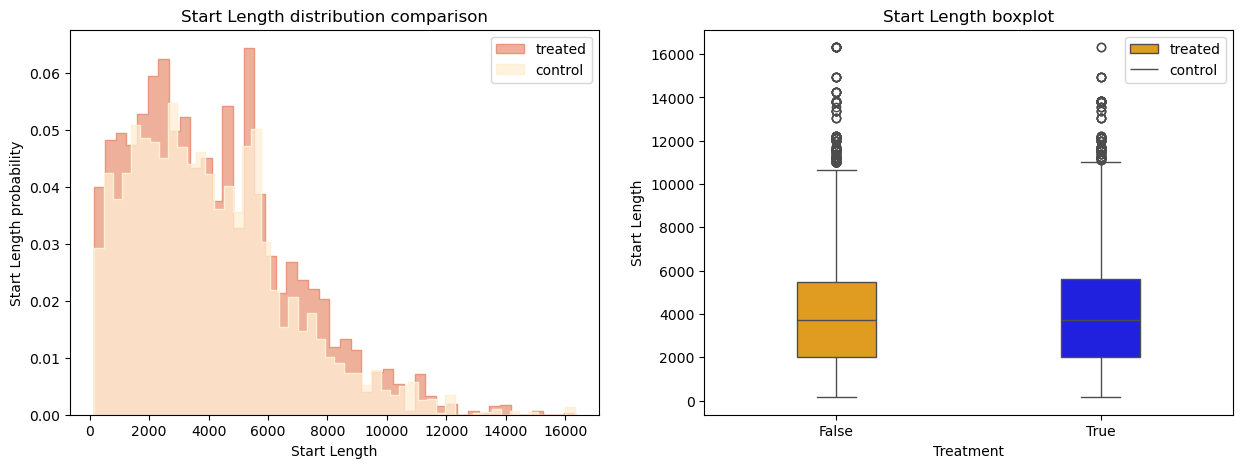

In [237]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax = sns.histplot(df_analysis[df_analysis.treatment]["startLength"], stat='probability', color='darksalmon', label='treated', element="step", ax=axes[0])
ax = sns.histplot(df_analysis[~df_analysis.treatment]["startLength"], stat='probability', color='papayawhip', label='control', element="step", ax=axes[0])


bx = sns.boxplot(data=df_analysis, y="startLength", x="treatment", ax=axes[1], width=0.3, palette=["orange", "blue"])

ax.set(title='Start Length distribution comparison', xlabel="Start Length", ylabel='Start Length probability')
bx.set(title='Start Length boxplot', xlabel="Treatment", ylabel='Start Length')
ax.legend()
bx.set_label(["treated","control"])
bx.legend(labels=["treated","control"])
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


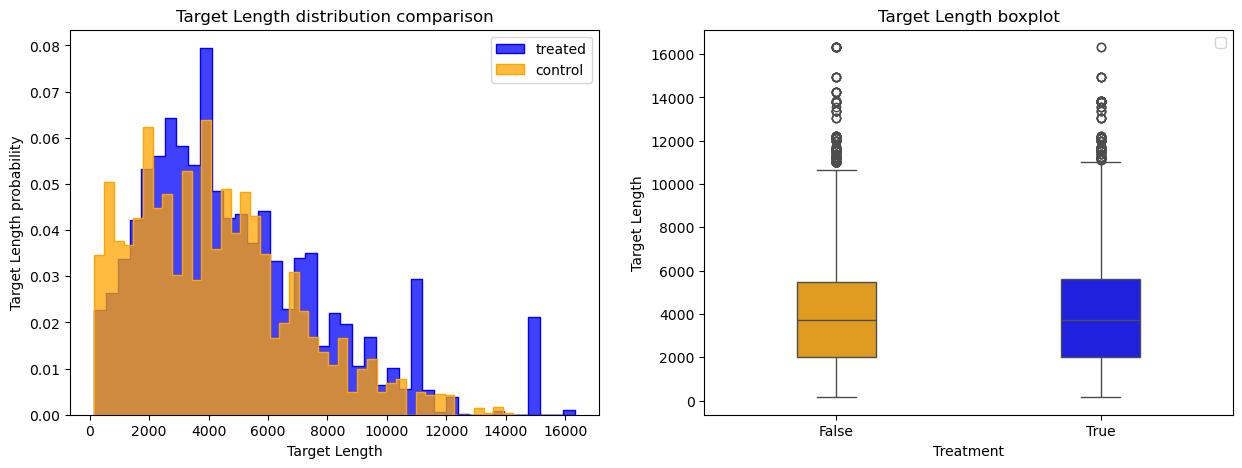

In [85]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax = sns.histplot(df_analysis[df_analysis.treatment]["targetLength"], stat='probability', color='blue', label='treated', element="step", ax=axes[0])
ax = sns.histplot(df_analysis[~df_analysis.treatment]["targetLength"], stat='probability', color='orange', label='control', element="step", ax=axes[0])

bx = sns.boxplot(x="treatment", y="startLength", data=df_analysis, ax=axes[1], palette=["orange", "blue"], width=0.3)

ax.set(title='Target Length distribution comparison', xlabel="Target Length", ylabel='Target Length probability')
bx.set(title='Target Length boxplot', xlabel="Treatment", ylabel='Target Length')

ax.legend()
bx.legend()
plt.show()


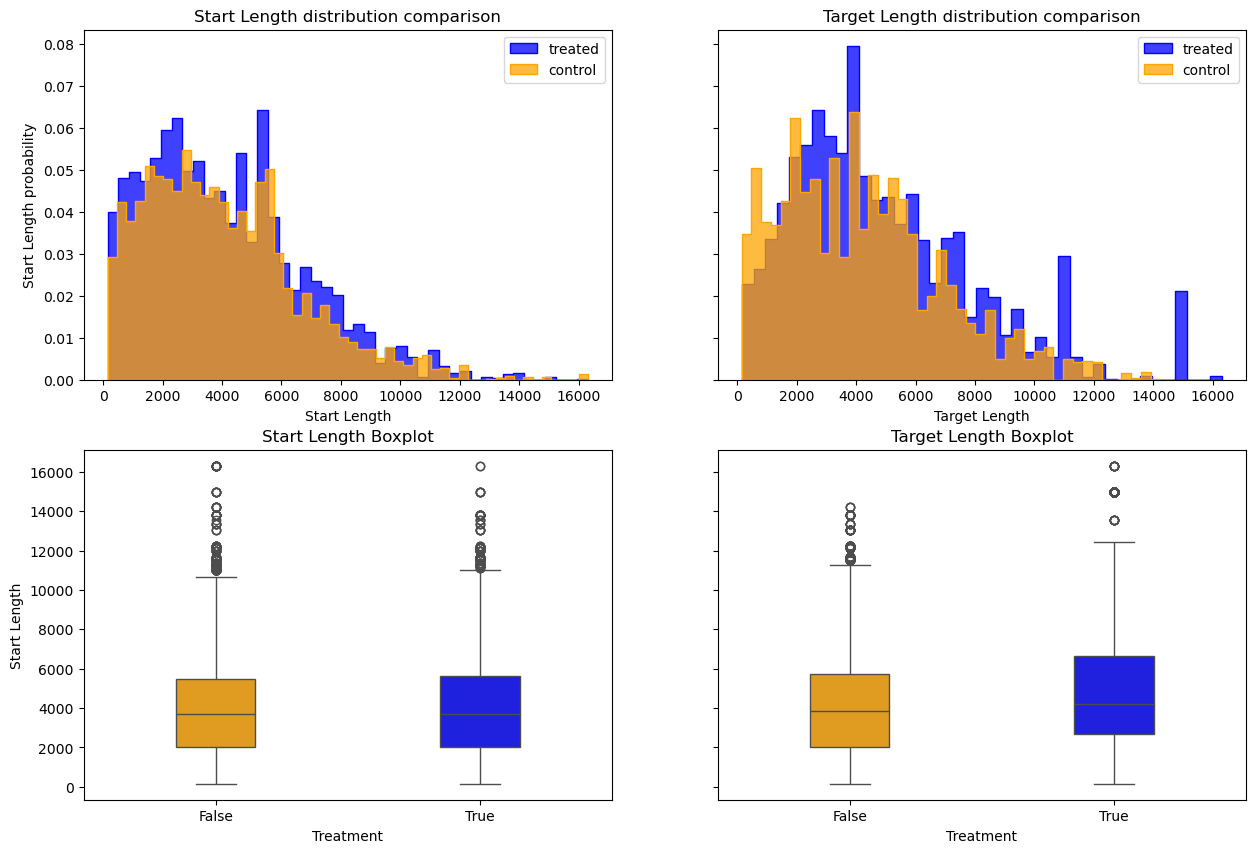

In [232]:
cols = ["startLength", "targetLength"]
names = ["Start Length", "Target Length"]

fig, axes = plt.subplots(nrows=2, ncols=len(cols), figsize=(15, 10), sharey="row")


for i, col in enumerate(cols):
    ax = sns.histplot(df_analysis[df_analysis.treatment][col], stat='probability', color='blue', label='treated', element="step", ax=axes[0,i],) # treatment
    ax = sns.histplot(df_analysis[~df_analysis.treatment][col], stat='probability', color='orange', label='control', element="step", ax=axes[0,i]) # control
    ax.set(title=f'{names[i]} distribution comparison', xlabel=names[i], ylabel=f'{names[i]} probability')
    ax.legend()
    
    ax = sns.boxplot(x="treatment", y=col, data=df_analysis, ax=axes[1,i], palette=["orange", "blue"], width=0.3)
    ax.set(title=f'{names[i]} Boxplot', xlabel='Treatment', ylabel=names[i])


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


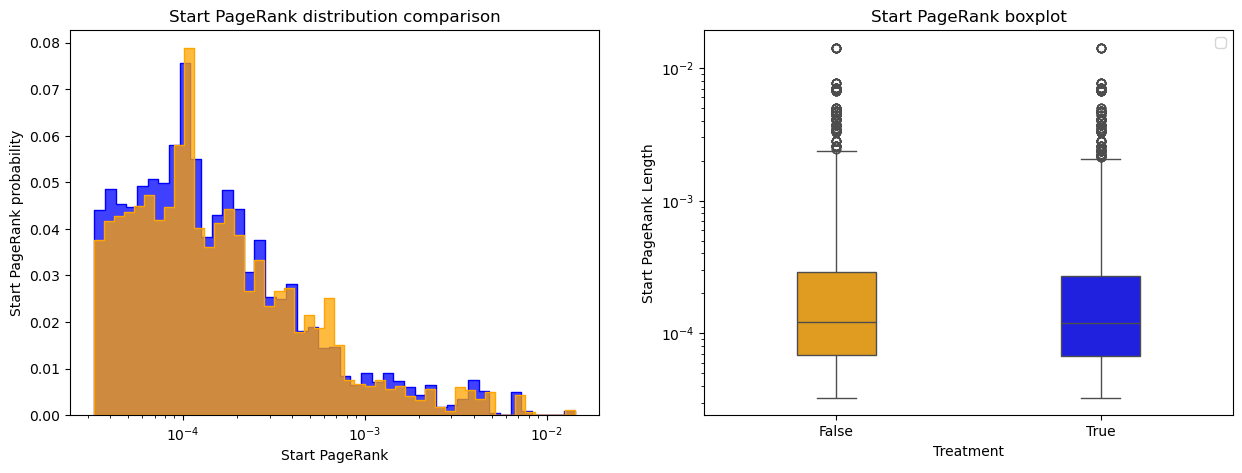

In [87]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax = sns.histplot(df_analysis[df_analysis.treatment]["startPageRank"], stat='probability', color='blue', label='treated', element="step", ax=axes[0], log_scale=True)
ax = sns.histplot(df_analysis[~df_analysis.treatment]["startPageRank"], stat='probability', color='orange', label='control', element="step", ax=axes[0],log_scale=True)

bx = sns.boxplot(x="treatment", y="startPageRank", data=df_analysis, ax=axes[1], palette=["orange", "blue"], width=0.3, log_scale=True)

ax.set(title='Start PageRank distribution comparison', xlabel="Start PageRank", ylabel='Start PageRank probability')
bx.set(title='Start PageRank boxplot', xlabel="Treatment", ylabel='Start PageRank Length')
plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


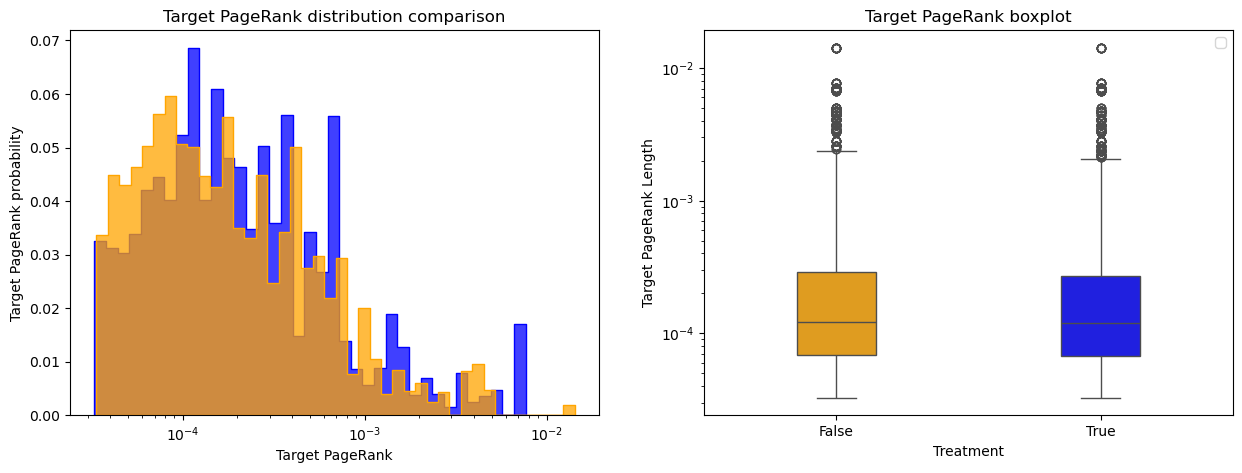

In [88]:
fig, axes =  plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax = sns.histplot(df_analysis[df_analysis.treatment]["targetPageRank"], stat='probability', color='blue', label='treated', element="step", ax=axes[0],log_scale=True)
ax = sns.histplot(df_analysis[~df_analysis.treatment]["targetPageRank"], stat='probability', color='orange', label='control', element="step", ax=axes[0], log_scale=True)

bx = sns.boxplot(x="treatment", y="startPageRank", data=df_analysis, ax=axes[1], palette=["orange", "blue"], width=0.3, log_scale=True)

ax.set(title='Target PageRank distribution comparison', xlabel="Target PageRank", ylabel='Target PageRank probability')
bx.set(title='Target PageRank boxplot', xlabel="Treatment", ylabel='Target PageRank Length')
plt.legend()
plt.show()


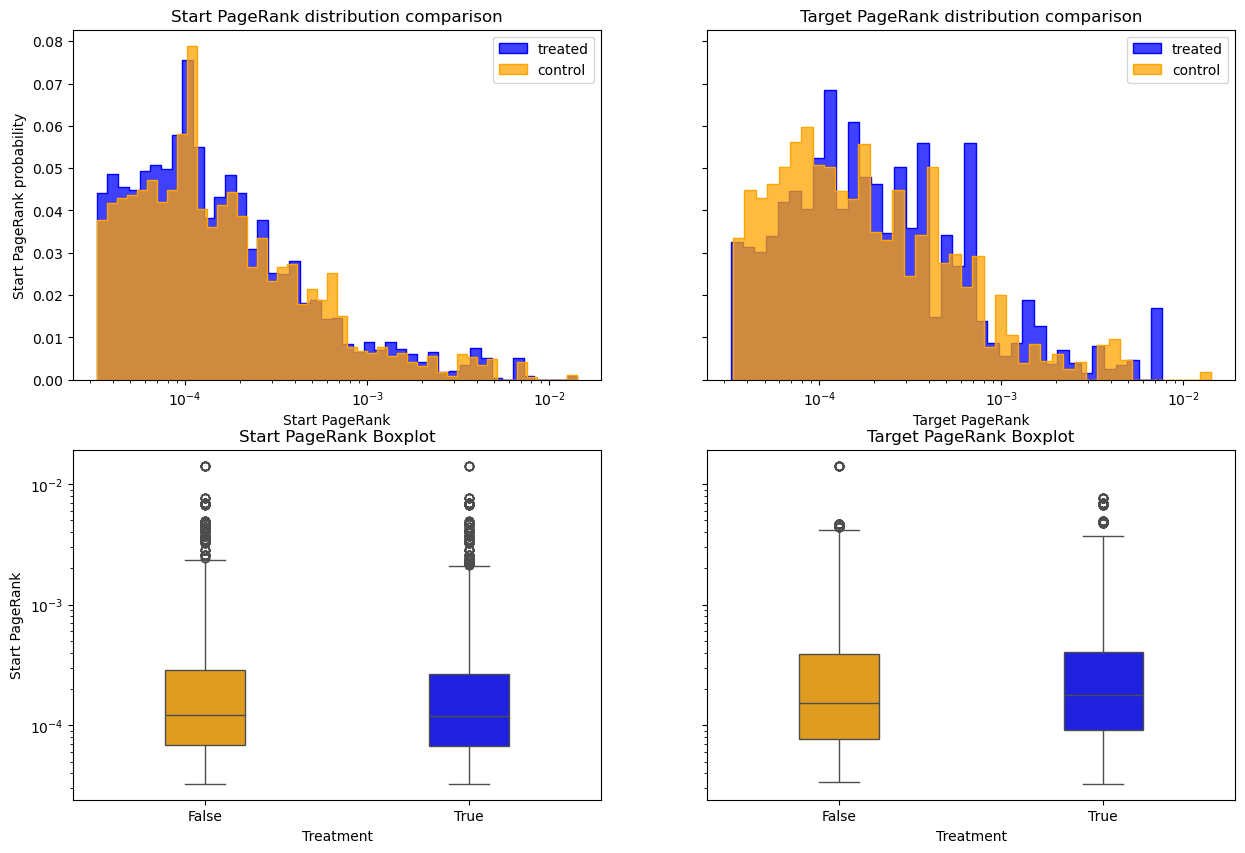

In [89]:
cols = ["startPageRank", "targetPageRank"]
names = ["Start PageRank", "Target PageRank"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey="row")


for i, col in enumerate(cols):
    ax = sns.histplot(df_analysis[df_analysis.treatment][col], stat='probability', color='blue', label='treated', element="step", ax=axes[0,i], log_scale=(True, False))
    ax = sns.histplot(df_analysis[~df_analysis.treatment][col], stat='probability', color='orange', label='control', element="step", ax=axes[0,i], log_scale=(True, False))
    ax.set(title=f'{names[i]} distribution comparison', xlabel=names[i], ylabel=f'{names[i]} probability')
    ax.legend()

    ax = sns.boxplot(x="treatment", y=col, data=df_analysis, ax=axes[1,i], palette=["orange", "blue"], width=0.3, log_scale=True)
    ax.set(title=f'{names[i]} Boxplot', xlabel='Treatment', ylabel=names[i])

plt.show()

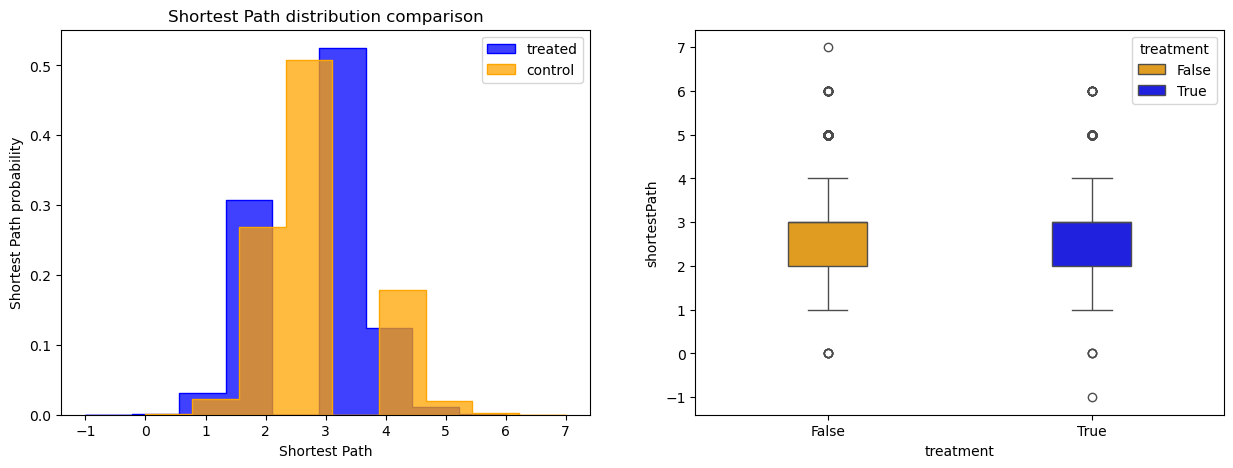

In [122]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))


ax = sns.histplot(df_analysis[df_analysis.treatment]["shortestPath"], stat='probability', color='blue', label='treated', element="step", ax=axes[0], binwidth=0.8)
ax = sns.histplot(df_analysis[~df_analysis.treatment]["shortestPath"], stat='probability', color='orange', label='control', element="step", ax=axes[0], binwidth=0.8)
ax.set(title='Shortest Path distribution comparison', xlabel="Shortest Path", ylabel='Shortest Path probability')

bx = sns.boxplot(x="treatment", y="shortestPath", data=df_analysis, ax=axes[1], palette=["orange", "blue"], width=0.3)
ax.legend()

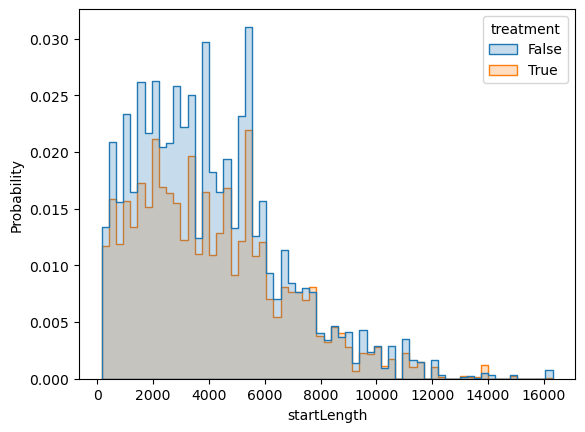

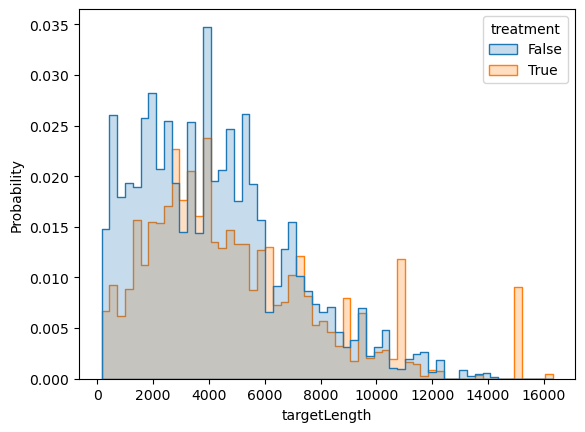

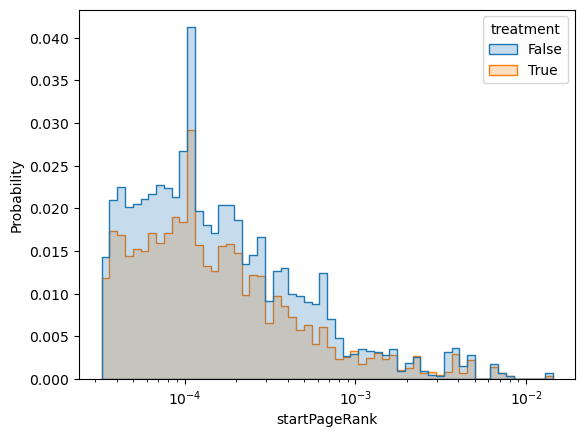

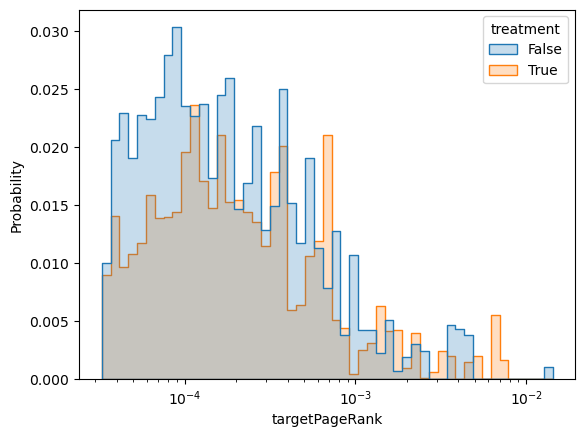

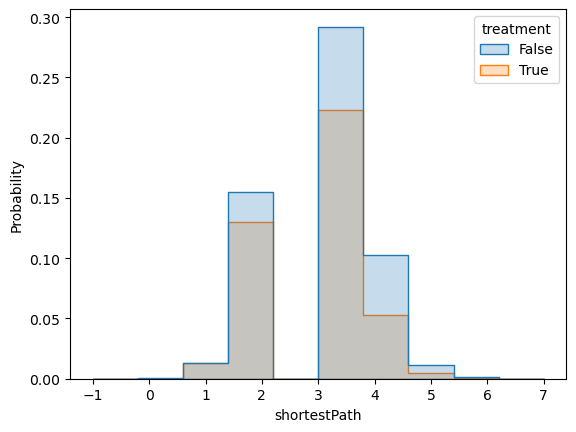

In [231]:
cols=["startLength","targetLength","startPageRank","targetPageRank","shortestPath"]
for i, col in enumerate(cols):
    ax = sns.histplot(data=df_analysis, 
                      x=col, 
                      hue="treatment", 
                      stat='probability',
                      element="step",
                      log_scale=True if col in ["startPageRank", "targetPageRank"] else None,
                      binwidth=0.8 if col=="shortestPath" else None,
                      )
    plt.show()

In [152]:
df_analysis[cols]

,startLength,targetLength,startPageRank,targetPageRank,shortestPath
0,7496,2654,0.000186,0.000055,3
1,7496,4047,0.000186,0.000159,2
2,7496,4780,0.000186,0.000243,2
3,7496,4801,0.000186,0.000107,2
4,7496,7377,0.000186,0.000706,2
...,...,...,...,...,...
19159,6033,1086,0.000078,0.000037,4
19160,596,2692,0.000051,0.000175,3
19161,2305,2007,0.000100,0.000053,3
19162,872,1098,0.000039,0.000045,4


In [205]:
geom_mean_sLen = df_analysis.groupby("treatment").startLength.agg(scipy.stats.gmean)
geom_mean_tLen = df_analysis.groupby("treatment").targetLength.agg(scipy.stats.gmean)
geom_mean_sPG = df_analysis.groupby("treatment").startPageRank.agg(scipy.stats.gmean)
geom_mean_tPG = df_analysis.groupby("treatment").targetPageRank.agg(scipy.stats.gmean)
geom_mean_sPath = df_analysis.groupby("treatment").shortestPath.agg(scipy.stats.gmean)
print(geom_mean_sLen, geom_mean_tLen, geom_mean_sPG, geom_mean_tPG, geom_mean_sPath)


treatment
False    3119.854406
True     3135.438803
Name: startLength, dtype: float64 treatment
False    3221.095888
True     3893.795033
Name: targetLength, dtype: float64 treatment
False    0.000158
True     0.000153
Name: startPageRank, dtype: float64 treatment
False    0.000180
True     0.000212
Name: targetPageRank, dtype: float64 treatment
False    0.0
True     NaN
Name: shortestPath, dtype: float64


,treatment,Variable,Geometric Mean
0,False,startLength,3119.854406
1,False,targetLength,3221.095888
2,True,startLength,3135.438803
3,True,targetLength,3893.795033


,treatment,Variable,Geometric Mean
0,False,startPageRank,0.000158
1,False,targetPageRank,0.000158
2,True,startPageRank,0.000153
3,True,targetPageRank,0.000153


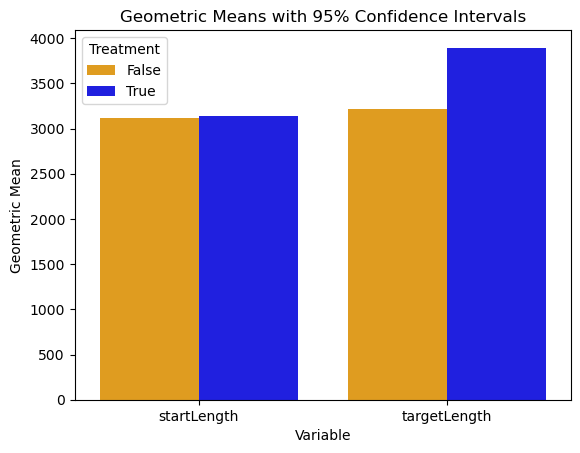

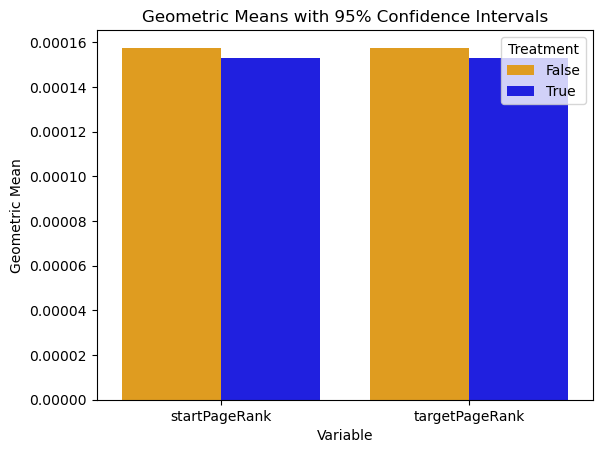

In [212]:
# CHATGPT:

# Calculate geometric means with confidence intervals
geom_means_ci_1 = df_analysis.groupby('treatment').agg(
    startLength=('startLength', scipy.stats.gmean),
    targetLength=('targetLength', scipy.stats.gmean),
)

geom_means_ci_2 = df_analysis.groupby('treatment').agg(
    startPageRank=('startPageRank', scipy.stats.gmean),
    targetPageRank=('startPageRank', scipy.stats.gmean),
)


# Reshape the DataFrame for plotting
geom_means_ci_1 = geom_means_ci_1.stack().reset_index().rename(columns={0: 'Geometric Mean', 'level_1': 'Variable'})
geom_means_ci_2 = geom_means_ci_2.stack().reset_index().rename(columns={0: 'Geometric Mean', 'level_1': 'Variable'})

display(geom_means_ci_1, geom_means_ci_2)

# Plot using Seaborn
sns.barplot(
    x='Variable',
    y='Geometric Mean',
    hue='treatment',
    data=geom_means_ci_1,
    capsize=0.1,
    estimator=scipy.stats.gmean,  # Specify the estimator
    errorbar='ci',  # Set the method for confidence interval
    n_boot=10000,  # Number of bootstrap samples
    palette=["orange","blue"]
)

plt.title('Geometric Means with 95% Confidence Intervals')
plt.xlabel('Variable')
plt.ylabel('Geometric Mean')
plt.legend(title='Treatment')
plt.show()

sns.barplot(x='Variable', y='Geometric Mean', hue='treatment', data=geom_means_ci_2, errorbar=("ci", 95), capsize=0.1, palette=["orange", "blue"])

plt.title('Geometric Means with 95% Confidence Intervals')
plt.xlabel('Variable')
plt.ylabel('Geometric Mean')
plt.legend(title='Treatment')
plt.show()
